# Eurosat Coding Challenge

Authors: Johannes Wenz, Philipp John

In [2]:
# import standard python libraries
from datetime import datetime
import numpy as np
import csv
from torchvision import transforms
from torchvision.models import resnet34
from torch.utils.data import Dataset, random_split
from tqdm import tqdm

# import the PyTorch deep learning library
import torch
from torch import nn


# import matplotlib, seaborn, and PIL data visualization libary
import matplotlib.pyplot as plt
%matplotlib inline

import rasterio as rio
from rasterio.plot import reshape_as_image

## Load data

In [ ]:
import os
import requests
import shutil

#If drive file in drive is available load it from there, otherwise download from source
drive_path = "/content/drive/MyDrive/MLFiles/EuroSATallBands.zip"
url = "https://madm.dfki.de/files/sentinel/EuroSATallBands.zip"

if os.path.isfile(drive_path):
  shutil.copyfile(drive_path, "EuroSATallBands.zip")
else:
  # Download the file
  response = requests.get(url, stream=True, verify=False)
  response.raise_for_status()  # Raise exception if invalid response
  with open("EuroSATallBands.zip", "wb") as out_file:
      out_file.write(response.content)
  print("File downloaded successfully.")

In [ ]:
!unzip -q EuroSATallBands.zip
!mv ds/images/remote_sensing/otherDatasets/sentinel_2/tif eurosat

In [3]:
eurosat_dir = "EuroSATallBands/ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
testset_dir = "testset/testset"

In [ ]:
!wget https://cdn.discordapp.com/attachments/1006556110880264319/1105245065506467861/aiml-coding-challenge-fs23_1.zip
!unzip -q aiml-coding-challenge-fs23_1.zip
!mv testset testset2
!mv testset2/testset testset
!rm -r testset2
!pip install rasterio

## Setup

Setting random seeds for reproducibility and dictionaries that map class names to their respective numerical labels and vice versa

In [4]:
# init deterministic seed
SEED_VALUE = 1337

np.random.seed(SEED_VALUE) # set numpy seed
torch.manual_seed(SEED_VALUE) # set pytorch seed CPU
# init deterministic GPU seed
torch.cuda.manual_seed(SEED_VALUE)

# set cpu or gpu enabled device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(DEVICE)))

IMAGE_SIZE = 224

[LOG] notebook with cuda computation enabled


In [5]:
class_to_index = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
}

classes_idx = {
    0: 'AnnualCrop',
    1: 'Forest',
    2: 'HerbaceousVegetation',
    3: 'Highway',
    4: 'Industrial',
    5: 'Pasture',
    6: 'PermanentCrop',
    7: 'Residential',
    8: 'River',
    9: 'SeaLake'
}

CLASSES = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake"]

## Dataloader

Load and preprocess the data from the given directories

In [101]:
class CustomImageDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform

        self.transform = transform
        files_and_folders = os.listdir(eurosat_dir)
        self.folder_names = [f for f in files_and_folders if os.path.isdir(os.path.join(eurosat_dir, f))]
        self.name_to_id = {name: id for (id, name) in enumerate(sorted(self.folder_names))}

        self.all_paths = []
        self.all_label = []
        for root, dirs, files in os.walk(eurosat_dir):
            # iterate through all files in the current directory
            for file in files:
                # get the path of the file

                file_path = os.path.join(root, file)
                file_path = file_path.replace("\\\\", "/")

                if not file_path.endswith(".tif"):
                    continue
                # print the path of the fil
                self.all_paths.append(file_path)
                self.all_label.append(self.name_to_id[root.replace("\\", "/").split("/")[-1]])

    def __len__(self):
        return len(self.all_paths)

    # TODO Potentially test that the channels get correctly loaded and transformed
    def __getitem__(self, idx):
        path_i = self.all_paths[idx]
        label = self.all_label[idx]
        # TODO Make if for file type - Handle test data
        with rio.open(path_i, "r") as d:
            image = d.read([2,3,4,5,6,7,8,11,12,13]).astype(float)
            image = reshape_as_image(image)
        #image = default_loader(img_path)

        #image = normalize_for_display(image)

        b8 = image[:, :, 7]
        b4 = image[:, :, 3]
        ndvi = (b8-b4) / (b8+b4)

        ndvi = np.nan_to_num(ndvi, 0.001)
        ndvi_filter = np.where(ndvi > 0.5, ndvi, 0.001)

        image = np.append(image, np.expand_dims(ndvi, axis=2), axis=2)

       # ndvi_filter = np.where(ndvi > 0.5, ndvi, 0.001)

        image = np.append(image, np.expand_dims(ndvi_filter, axis=2), axis=2)

        if self.transform:
            image = self.transform(image)
        return image, label

In [102]:
class TestImageDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.all_paths = []
        self.all_label = []
        for file in os.listdir(testset_dir):

            file_path = os.path.join(testset_dir, file)
            if not file_path.endswith(".npy"):
                continue
                # print the path of the fil
            self.all_label.append(file.replace("test_", "").replace(".npy", ""))
            self.all_paths.append(file_path)

    def __len__(self):
        return len(self.all_paths)

    # TODO Potentially test that the channels get correctly loaded and transformed
    def __getitem__(self, idx):
        path_i = self.all_paths[idx]
        label = self.all_label[idx]
        # TODO Make if for file type - Handle test data
        arr = np.load(path_i)
        arr = arr.astype(np.float32)
        arr = np.concatenate((arr[:, :, :8], arr[:, :, 9:]), axis=2)
        arr = arr[:, :, 1:]

        subarray_1 = arr[..., :7]
        subarray_2 = arr[..., 8:]

        # Get the subarray at index 8
        subarray_8 = arr[..., 8]

        # Concatenate the subarrays

        b8 = arr[:, :, 7]
        b4 = arr[:, :, 3]
        ndvi = (b8-b4) / (b8+b4)

        ndvi_filter = np.where(ndvi > 0.5, ndvi, 0)

        arr = np.append(arr, np.expand_dims(ndvi_filter, axis=2), axis=2)
        if self.transform:
            arr = self.transform(arr)
        return arr, label

## Transformations

Standard preprocessing steps to help to increase the performance of the model and reduce overfitting

In [106]:
def calculate_mean_and_std(dataset, num_channels=3):
    # Create a DataLoader without shuffling or batching
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

    mean = torch.zeros(num_channels)
    std = torch.zeros(num_channels)

    for image, _ in tqdm(loader):
        # Convert the image to a tensor and normalize it
        for i in range(num_channels):
            # Calculate the mean and std for each channel
            mean[i] += image[:,i,:,:].mean()
            std[i] += image[:,i,:,:].std()

    # Average across all images
    mean /= len(loader)
    std /= len(loader)

    return mean.tolist(), std.tolist()

In [49]:
mean_trainset = CustomImageDataset(transform=transforms.ToTensor())
means_train, stds_train = calculate_mean_and_std(mean_trainset, num_channels=11)
print(means_train, stds_train)

100%|██████████| 27000/27000 [03:28<00:00, 129.74it/s]

tensor([1117.2059, 1041.8867,  946.5523, 1199.1858, 2003.0063, 2374.0137,
        2301.2292,  732.1799, 1820.6937, 1118.2045, 2599.7817]) tensor([153.7739, 187.6983, 278.1248, 227.9235, 355.9322, 455.1331, 530.7792,
         98.9300, 378.1604, 303.1066, 502.1653])


In [50]:
training_data_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
        transforms.Normalize(mean = means_train, std = stds_train)
])

In [51]:
validation_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = means_train, std=stds_train),
    transforms.Resize(IMAGE_SIZE)
])

## Defining the Model

Creates a model architecture based on the ResNet34 network which has been pretrained on ImageNet. The model is then slightly modified to better suit the task at hand:

1. Adaptated final fully connected layer ("head") into a prediction about which of the 10 classes the input image belongs to
2. Modified first convolutional layer to accept 11 input channels instead of the original 3 (i.e., all bands vs. only RGB)
3. Initialized optimizer for training


In [94]:
def create_model():
    # load up the ResNet50 model
    new_model = resnet34(pretrained=True)

    numFeatures = new_model.fc.in_features

    # loop over the modules of the model and set the parameters of
    # batch normalization modules as not trainable
    for module, param in zip(new_model.modules(), new_model.parameters()):
        if isinstance(module, nn.BatchNorm2d):
            param.requires_grad = False

    # define the network head and attach it to the model
    headModel = nn.Sequential(
        nn.Linear(numFeatures, len(classes_idx))
    )

    new_model.fc = headModel

    #send to gpu
    new_model = new_model.to(DEVICE)

    #Modify the input layer to accomodate more channels for the bands
    #https://discuss.pytorch.org/t/how-to-modify-the-input-channels-of-a-resnet-model/2623/10

    layer = new_model.conv1
    new_in_channels = 11
    # Creating new Conv2d layer
    new_layer = nn.Conv2d(in_channels=new_in_channels,
                      out_channels=layer.out_channels,
                      kernel_size=layer.kernel_size,
                      stride=layer.stride,
                      padding=layer.padding,
                      bias=layer.bias)

    copy_weights = 0 # Here will initialize the weights from new channel with the red channel weights

    new_layer_weight = new_layer.weight.clone()
    new_layer_weight[:, :layer.in_channels, :, :] = layer.weight.clone()
    for i in range(new_in_channels - layer.in_channels):
        channel = layer.in_channels + i
        new_layer_weight[:, channel:channel+1, :, :] = layer.weight[:, copy_weights:copy_weights+1, :, :].clone()
    new_layer.weight = nn.Parameter(new_layer_weight)

    new_model.conv1 = new_layer

    opt = torch.optim.Adam(new_model.parameters())

    return new_model, opt

 ## Training the Model

Trains the model for a given number of epochs. For each epoch, we iterate over the training data, feed the data through the model to get predictions, calculate the loss by comparing the predictions to the true labels, and then backpropagate the error to update the model's parameters.

Added logs to see the training loss and accuracy for each mini-batch and each epoch. We save the model parameters at the end of each epoch.

If a validation dataloader is provided, the function also evaluates the model on the validation data after each epoch.

In [53]:
# initialize loss function and optimizer
lossFunc = nn.CrossEntropyLoss()
lossFunc = lossFunc.to(DEVICE)


In [22]:
#init metrics
train_epoch_losses = []
accuracy_epochs = []
all_mini_losses = []
all_mini_accs = []

val_losses = []
val_accs = []

In [95]:

def train_model(epochs, model, train_dataloader,val_dataloader, lossFunc, opt):
    global all_mini_losses, all_mini_accs
    torch.manual_seed(SEED_VALUE)
    torch.cuda.manual_seed(SEED_VALUE)
    # initialize a dictionary to store training history
    print("Starting Network training")
    model.to(DEVICE)

    for e in range(epochs):
        train_mini_batch_losses = []
        train_mini_batch_accs = []

        tq_dataloader = tqdm(train_dataloader)
        model.train()

        for (i, (images, labels)) in enumerate(tq_dataloader):
            (images, labels) = (images.to(DEVICE, dtype=torch.float), labels.to(DEVICE))

            #predict
            pred = model(images)

            #get the most likely label
            pred_max = pred.argmax(dim=1)

            #calculate loss
            loss = lossFunc(pred, labels)

            opt.zero_grad()

            loss.backward()

            opt.step()

            #calculate accuracy
            correct = (pred_max == labels).sum()
            acc = correct / images.size(0)
            train_acc = acc*100

            train_mini_batch_losses.append(loss.data.item())
            train_mini_batch_accs.append(train_acc.item())

            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            tq_dataloader.set_description("[LOG {}] epoch: {}, batch:{} train-loss; {}, train-accuracy; {}".format(str(now), str(e + 1), str(i + 1), str(loss.item()), str(train_acc.item())))


        #calculate metrics for the epoch
        train_epoch_loss = np.mean(train_mini_batch_losses)
        train_epoch_acc = np.mean(train_mini_batch_accs)

        all_mini_losses = all_mini_losses + train_mini_batch_losses
        all_mini_accs = all_mini_accs + train_mini_batch_accs

        train_epoch_losses.append(train_epoch_loss)
        accuracy_epochs.append(train_epoch_acc)

        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print("[LOG {}] epoch: {}, train-loss; {}, accuracy; {}".format(str(now), str(e + 1), str(train_epoch_loss), str(train_epoch_acc)))

        model_name = "model_epoch_{}.pth".format(str(e + 1))

        #save the model after every epoch
        torch.save(model, model_name)

        if val_dataloader is not None:
            model.eval()
            print("Validating...")
            val_mini_batch_acc = []
            val_mini_batch_losses = []
            #Evaulate on the val set
            with torch.no_grad():
                for (images, labels) in tqdm(val_dataloader):
                    #Mostly the same as in the training loop
                    images, labels = images.to(DEVICE, dtype=torch.float), labels.to(DEVICE)
                    pred = model(images)
                    pred_max = torch.argmax(pred, dim=1)
                    loss = lossFunc(pred, labels)
                    correct = (pred_max == labels).sum()
                    acc = correct / images.size(0)
                    acc = acc*100
                    val_mini_batch_acc.append(acc.item())
                    val_mini_batch_losses.append(loss.data.item())

            # compute the average validation loss and accuracy for this epoch
            val_loss = np.mean(val_mini_batch_losses)
            val_acc = np.mean(val_mini_batch_acc)

            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print("Validation step done. Loss: ", val_loss, "Accuracy: ", val_acc)

        # print the training and validation loss and accuracy for this epoch
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print("[LOG {}] epoch: {}, train-loss: {:.4f}, train-accuracy: {:.4f}".format(now, e+1, train_epoch_loss, train_epoch_acc))

    return train_epoch_losses, accuracy_epochs


## Splitting the Dataset

Split data into training and validation sets using train_test_split from scikit-learn. Stratified split ensures that the distribution of classes is the same in both sets.

In [96]:
from sklearn.model_selection import train_test_split

train_dataset = CustomImageDataset(training_data_transformations)
val_dataset = CustomImageDataset(validation_transform)

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.all_label,
    stratify=train_dataset.all_label,
    test_size=0.1,
    random_state=SEED_VALUE
)

#Do the split with seeded indices
train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

print("Train: ", len(train_dataloader), "Val: ", len(val_dataloader))

Train:  380 Val:  43


## Train with Split data

In [14]:
#Train model with validation set
model, opt = create_model()
train_model(6, model, train_dataloader, val_dataloader, lossFunc, opt)

C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Network training


  0%|          | 0/380 [00:00<?, ?it/s]C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[LOG 20230521-12:38:04] epoch: 1, batch:380 train-loss; 0.4677598774433136, train-accuracy; 88.63636779785156: 100%|██████████| 380/380 [09:06<00:00,  1.44s/it]


[LOG 20230521-12:38:04] epoch: 1, train-loss; 0.707400210789944, accuracy; 78.6296351784154
Validating...


100%|██████████| 43/43 [00:29<00:00,  1.47it/s]


Validation step done. Loss:  0.2083393706138744 Accuracy:  93.25339153201081
[LOG 20230521-12:38:33] epoch: 1, train-loss: 0.7074, train-accuracy: 78.6296


[LOG 20230521-12:47:30] epoch: 2, batch:380 train-loss; 0.5363180637359619, train-accuracy; 84.09091186523438: 100%|██████████| 380/380 [08:57<00:00,  1.41s/it]


[LOG 20230521-12:47:30] epoch: 2, train-loss; 0.39162699274326623, accuracy; 89.02474582069799
Validating...


100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


Validation step done. Loss:  0.20336942790552628 Accuracy:  92.99903106689453
[LOG 20230521-12:47:59] epoch: 2, train-loss: 0.3916, train-accuracy: 89.0247


[LOG 20230521-12:56:59] epoch: 3, batch:380 train-loss; 0.3303949534893036, train-accuracy; 88.63636779785156: 100%|██████████| 380/380 [09:00<00:00,  1.42s/it]


[LOG 20230521-12:56:59] epoch: 3, train-loss; 0.32072435739009003, accuracy; 90.78012859946803
Validating...


100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


Validation step done. Loss:  0.16610429895132087 Accuracy:  95.96656976744185
[LOG 20230521-12:57:28] epoch: 3, train-loss: 0.3207, train-accuracy: 90.7801


[LOG 20230521-13:06:30] epoch: 4, batch:380 train-loss; 0.555154025554657, train-accuracy; 81.81818389892578: 100%|██████████| 380/380 [09:01<00:00,  1.43s/it]


[LOG 20230521-13:06:30] epoch: 4, train-loss; 0.2871159098062076, accuracy; 91.82715311552349
Validating...


100%|██████████| 43/43 [00:28<00:00,  1.50it/s]


Validation step done. Loss:  0.11597886596140343 Accuracy:  96.40261627906976
[LOG 20230521-13:06:59] epoch: 4, train-loss: 0.2871, train-accuracy: 91.8272


[LOG 20230521-13:15:59] epoch: 5, batch:380 train-loss; 0.5817199349403381, train-accuracy; 90.90909576416016: 100%|██████████| 380/380 [09:00<00:00,  1.42s/it]


[LOG 20230521-13:15:59] epoch: 5, train-loss; 0.26773727544044196, accuracy; 92.51719498885305
Validating...


100%|██████████| 43/43 [00:28<00:00,  1.49it/s]


Validation step done. Loss:  0.14743881806904494 Accuracy:  95.34883720930233
[LOG 20230521-13:16:28] epoch: 5, train-loss: 0.2677, train-accuracy: 92.5172


[LOG 20230521-13:25:30] epoch: 6, batch:380 train-loss; 0.29988792538642883, train-accuracy; 84.09091186523438: 100%|██████████| 380/380 [09:01<00:00,  1.43s/it]


[LOG 20230521-13:25:30] epoch: 6, train-loss; 0.2501025536440705, accuracy; 92.89398924175062
Validating...


100%|██████████| 43/43 [00:29<00:00,  1.47it/s]

Validation step done. Loss:  0.09759654659171436 Accuracy:  97.38372093023256
[LOG 20230521-13:25:59] epoch: 6, train-loss: 0.2501, train-accuracy: 92.8940


([0.707400210789944,
  0.39162699274326623,
  0.32072435739009003,
  0.2871159098062076,
  0.26773727544044196,
  0.2501025536440705],
 [78.6296351784154,
  89.02474582069799,
  90.78012859946803,
  91.82715311552349,
  92.51719498885305,
  92.89398924175062])

## Plot loss and accuracy

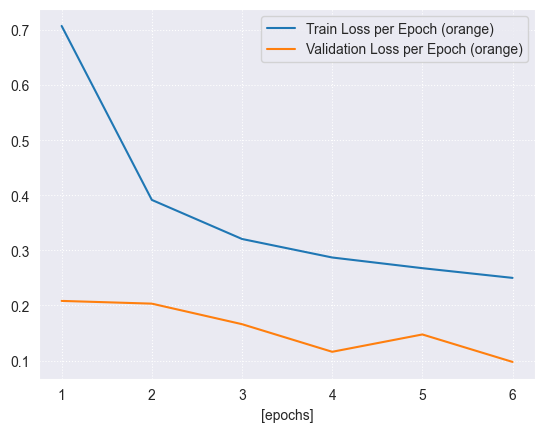

In [19]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label="Train Loss per Epoch (orange)")
ax.plot(np.array(range(1, len(val_losses)+1)), val_losses, label="Validation Loss per Epoch (orange)")

# add axis legends
ax.set_xlabel("[epochs]", fontsize=10)

# set plot legendS

plt.legend(loc="best", numpoints=1, fancybox=True)
plt.savefig('loss_6ep.png')

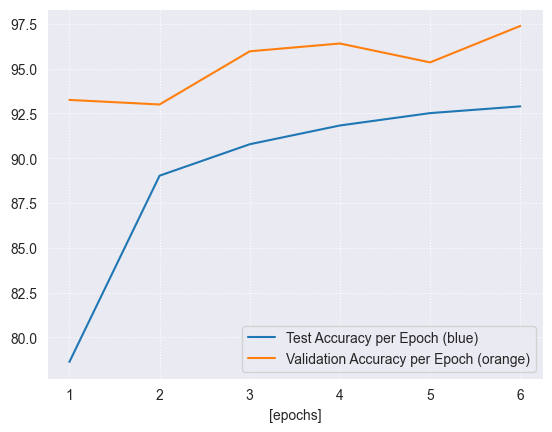

In [17]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(accuracy_epochs)+1)), accuracy_epochs, label='Test Accuracy per Epoch (blue)')
ax.plot(np.array(range(1, len(val_accs)+1)), val_accs, label="Validation Accuracy per Epoch (orange)")

# add axis legends
ax.set_xlabel("[epochs]", fontsize=10)

# set plot legendS

plt.legend(loc="best", numpoints=1, fancybox=True)
plt.savefig('accuracy_6ep.png')

In [ ]:
#Predictions for confusion matrix
y_true = []
y_pred = []

for i in tqdm(range(len(val_dataset))):
    x, y = val_dataset[i]
    x = x.to(DEVICE, dtype=torch.float).unsqueeze(0)
    pred = model(x)
    batch_predictions = torch.argmax(pred, dim=1)

    y_true.append(classes_idx[y])
    y_pred.append(classes_idx[batch_predictions[0].item()])

In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig("confusion.png")
plt.show()

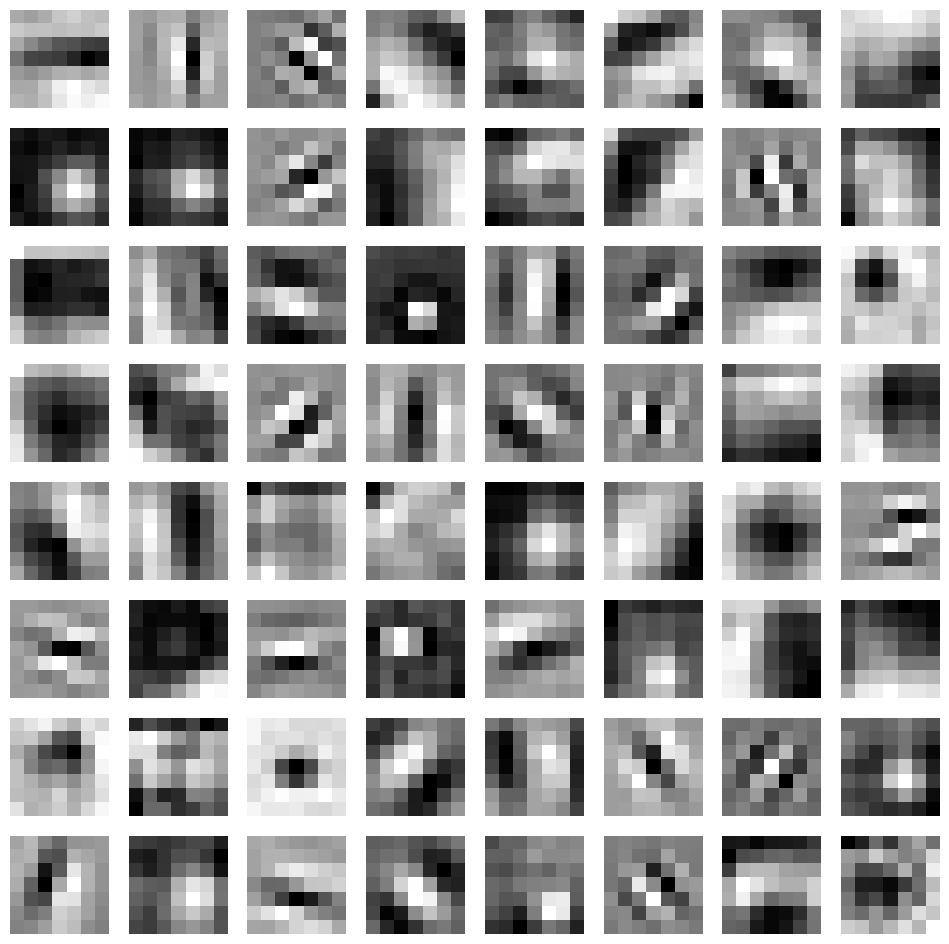

In [116]:
# Get the first convolutional layer
first_conv_layer = model.conv1

# Get the weights of the first convolutional layer
weights = first_conv_layer.weight.data.cpu().numpy()

# Get the number of filters
num_filters = weights.shape[0]

# Plot the filters
fig = plt.figure(figsize=(12, 12))

# We'll arrange the plots in a grid with sqrt(num_filters) rows and columns
rows_cols = int(np.sqrt(num_filters))

for i in range(rows_cols * rows_cols):
    ax = fig.add_subplot(rows_cols, rows_cols, i+1)

    # Display each channel separately, because each channel responds to different kinds of features
    for channel in range(11): # for each RGB color channel
        ax.imshow(weights[i, channel, :, :], cmap='gray')

    # Remove grid and axis labels
    ax.axis('off')

plt.show()


In [55]:
train_dataset = CustomImageDataset(training_data_transformations)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

#Set val dataloader to none, since we skip that step here
val_dataloader = None

# Train with full dataset for test set classification

In [97]:
model, opt = create_model()
#retrain model on full dataset for submissions model
#6 epochs where the best in that constellation
train_model(6, model, train_dataloader, val_dataloader, lossFunc, opt)

#Comment out if you don't want to load the model


C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting Network training


  0%|          | 0/380 [00:00<?, ?it/s]C:\Users\aytoi\miniconda3\envs\ml-notebooks\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[LOG 20230521-20:25:24] epoch: 1, batch:380 train-loss; 0.36138927936553955, train-accuracy; 84.09091186523438: 100%|██████████| 380/380 [10:09<00:00,  1.60s/it]


[LOG 20230521-20:25:24] epoch: 1, train-loss; 0.4821449343703295, accuracy; 84.96635766280325
Validating...


100%|██████████| 43/43 [00:30<00:00,  1.42it/s]


Validation step done. Loss:  0.18391225296397543 Accuracy:  93.83478688084801
[LOG 20230521-20:25:54] epoch: 1, train-loss: 0.4821, train-accuracy: 84.9664


[LOG 20230521-20:35:47] epoch: 2, batch:380 train-loss; 0.16719554364681244, train-accuracy; 90.90909576416016: 100%|██████████| 380/380 [09:52<00:00,  1.56s/it]


[LOG 20230521-20:35:47] epoch: 2, train-loss; 0.2926972917820278, accuracy; 91.04515551516884
Validating...


100%|██████████| 43/43 [00:29<00:00,  1.46it/s]


Validation step done. Loss:  0.16434505313288333 Accuracy:  94.02858538960301
[LOG 20230521-20:36:17] epoch: 2, train-loss: 0.2927, train-accuracy: 91.0452


[LOG 20230521-20:40:31] epoch: 3, batch:162 train-loss; 0.12450270354747772, train-accuracy; 95.3125:  43%|████▎     | 162/380 [04:15<05:43,  1.58s/it]


KeyboardInterrupt: 

In [ ]:
!wget https://cdn.discordapp.com/attachments/1006556110880264319/1109955377228939435/model_71.pth

In [115]:
model = torch.load("model_71.pth")

In [107]:
#Since we have the testdata available we can calculate the means and stds for the test data. These differ greatly from the train set
mean_testset = TestImageDataset(transform=transforms.ToTensor())
means_test, stds_test = calculate_mean_and_std(mean_testset, num_channels=11)

print(means_test, stds_test)

100%|██████████| 4232/4232 [00:05<00:00, 833.14it/s]

[400.1496276855469, 628.8629760742188, 578.8707885742188, 943.4276123046875, 1826.243896484375, 2116.6650390625, 2205.976806640625, 2266.933349609375, 1487.6881103515625, 959.2361450195312, 0.1850024163722992] [209.14852905273438, 241.2066650390625, 301.10589599609375, 269.51385498046875, 420.2496032714844, 503.81842041015625, 598.0409545898438, 403.938232421875, 398.14324951171875, 342.4408264160156, 0.16295932233333588]


In [108]:
#Tranform for test data with different normalization values calculated above

test_data_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = means_test, std = stds_test),
    transforms.Resize(IMAGE_SIZE)
])

test_set = TestImageDataset(test_data_transformations)

## Evaluating the testset

In [109]:
#Turn on evaluation mode
model.eval()
predictions = []
with torch.no_grad():
  for i in tqdm(range(len(test_set))):
      pred = model(test_set[i][0].to(DEVICE, dtype=torch.float).unsqueeze(0))
      batch_predictions = torch.argmax(pred, dim=1)
      predictions.append((test_set[i][1], classes_idx[batch_predictions[0].item()]))

100%|██████████| 4232/4232 [00:35<00:00, 118.83it/s]


In [110]:
model.eval()
#Classify one image to get a sense of the model performance.
with torch.no_grad():
    pred = model(test_set[0][0].to(DEVICE, dtype=torch.float).unsqueeze(0))
    batch_predictions = torch.argmax(pred, dim=1)
    print(batch_predictions)

tensor([5], device='cuda:0')


In [111]:
#write te submission file
csv_file = "71percent_recon.csv"
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(["test_id", "label"])

    for prediction in predictions:
        writer.writerow(prediction)